# Differential Analysis with both GEO and RNA-Seq

Import everything from the imports notebook. This reads in all of the expression data as well as the functions needed to analyse differential expression data.

In [1]:
import NotebookImport
from Imports import *

importing IPython notebook from Imports

In [2]:
import seaborn as sns
sns.set_context('paper',font_scale=1.5)
sns.set_style('white')

Read in matched Gene expression data.

In [3]:
matched_rna = pd.read_hdf('/data_ssd/RNASeq_2014_07_15.h5', 'matched_tn')
rna_microarray = pd.read_hdf('/data_ssd/GEO_microarray_dx.h5', 'data')
matched_rna = rna_microarray.join(matched_rna)

###Run a simple screen for DX probes 
* Here we take the matched data and run a basic screen
* fc = 1 means that we have no foldchange buffer for a gene to be considered over or underexpressed in a patient 
* If there are ties or missing data, I omit these from the test.  This can cause underpowered tests which have extreme test statistics but weak p-values.  For this reason I filter all gene/probes/markers with a sample size of less than 300 patients.

In [8]:
dx_rna = binomial_test_screen(matched_rna, fc=1.)
dx_rna = dx_rna[dx_rna.num_dx > 300]

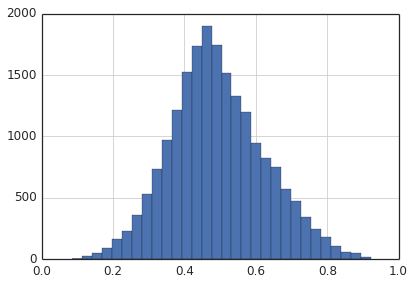

In [21]:
dx_rna.frac.hist(bins=30)

In [9]:
dx_rna.ix[['ADH1A','ADH1B','ADH1C']]

,num_ox,num_dx,frac,p
ADH1A,215,1548,0.14,5.53e-197
ADH1B,126,1330,0.09,3.57e-221
ADH1C,197,1116,0.18,7.05e-112


In [10]:
dx_rna.shape

(19880, 4)

In [11]:
dx_rna.p.rank().ix[['ADH1A','ADH1B','ADH1C']]

ADH1A     85
ADH1B     50
ADH1C    646
Name: p, dtype: float64

In [12]:
dx_rna.sort('p').head(10)

,num_ox,num_dx,frac,p
TOP2A,1450,1573,0.92,6.38e-288
MELK,1430,1572,0.91,5.50e-268
CENPF,1430,1573,0.91,3.03e-267
FOXM1,1428,1573,0.91,2.97e-265
KIF20A,1427,1573,0.91,2.90e-264
CXCL12,149,1573,0.09,2.60e-261
TPX2,1423,1572,0.91,4.72e-261
NDRG2,151,1573,0.10,2.33e-259
KIF4A,1420,1572,0.90,3.95e-258
EZH2,1418,1573,0.90,1.72e-255


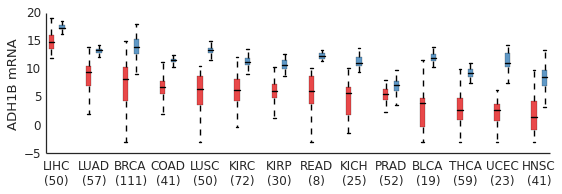

In [13]:
paired_bp_tn_split(matched_rna.ix['ADH1B'], codes, data_type='mRNA')

### Pathway and Gene Annotation Analysis

In [14]:
gs2 = gene_sets.ix[dx_rna.index].fillna(0)

In [15]:
rr = screen_feature(dx_rna.frac, rev_kruskal, gs2.T, 
                    align=False)
fp = (1.*gene_sets.T * dx_rna.frac).T.dropna().replace(0, np.nan).mean().order()
fp.name = 'mean frac'

Overexpressed pathways

In [16]:
rr.ix[ti(fp > .5)].join(fp).sort('p').head()

,H,p,q,mean frac
REACTOME_CELL_CYCLE_MITOTIC,344.12,8.08e-77,6.72e-74,0.67
REACTOME_GENE_EXPRESSION,279.18,1.13e-62,4.70e-60,0.60
REACTOME_MITOTIC_M_M_G1_PHASES,223.96,1.24e-50,3.43e-48,0.70
REACTOME_CELL_CYCLE_CHECKPOINTS,179.03,7.89e-41,1.64e-38,0.70
REACTOME_INFLUENZA_LIFE_CYCLE,174.09,9.45e-40,1.57e-37,0.64


Underexpressed pathways

In [17]:
rr.ix[ti(fp < .5)].join(fp).sort('p').head()

,H,p,q,mean frac
REACTOME_GPCR_LIGAND_BINDING,96.64,8.31e-23,2.09e-21,0.43
REACTOME_DOWNSTREAM_EVENTS_IN_GPCR_SIGNALING,96.48,9.00e-23,2.20e-21,0.43
KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION,85.16,2.75e-20,5.59e-19,0.42
REACTOME_BIOLOGICAL_OXIDATIONS,83.22,7.35e-20,1.46e-18,0.38
REACTOME_CLASS_A1_RHODOPSIN_LIKE_RECEPTORS,76.51,2.19e-18,3.96e-17,0.43


I am folling up on Fatty Acid Metabolism as opposed to biological oxidations, because it has a larger effect size, although the smaller gene-set size gives it a less extreme p-value.

In [18]:
def fig_1f(ax):
    v = pd.concat([dx_rna.frac, 
                   dx_rna.frac.ix[ti(gs2['REACTOME_CELL_CYCLE_MITOTIC']>0)],
                   dx_rna.frac.ix[ti(gs2['KEGG_FATTY_ACID_METABOLISM']>0)]])

    v1 = pd.concat([pd.Series('All Genes', dx_rna.frac.index), 
                    pd.Series('Cell Cycle\nMitotic',
                              ti(gs2['REACTOME_CELL_CYCLE_MITOTIC']>0)),
                    pd.Series('Fatty Acid\nMetabolism', 
                              ti(gs2['KEGG_FATTY_ACID_METABOLISM']>0))])
    v1.name = ''
    v.name = 'Fraction Overexpressed'
    violin_plot_pandas(v1, v, ann=None, ax=ax)
    prettify_ax(ax)
    return ax

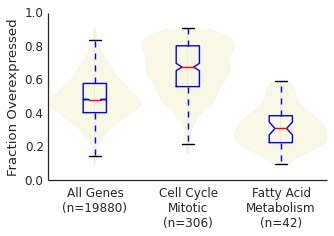

In [19]:
#Do not import
fig, ax = subplots(1,1, figsize=(5,3))
fig_1f(ax);